We will develop a classification pipeline to predict if a passenger from the Titanic survived or not. Go to Kaggle page for Titanic data and download the training and testing data sets. (Verification: 891 data points for training and 418 data points for testing dataset files) 

1. [70 pts] Preprocess the data, impute missing values as you see fit, and remove features 
that seem useless. 

In [1]:
## EXPLORATION
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; 
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (8,6)
sns.set(style="ticks", color_codes=True) 

## LOAD DATASET
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# examine a single sample
sample = df_train.iloc[0]
dtypes = df_train.dtypes
nans = 100 * df_train.isna().sum() / len(df_train)
categories = df_train.nunique()
print(pd.concat(
    (sample, dtypes, nans, categories), 
    keys=["Sample", "Datatypes", "NaN %", "Num Categories"], 
    axis=1)
)

# examine the categorical features
print("\nTicket values: ")
print(set(df_train["Ticket"].values[:20]))
print("\nCabin values: ")
print(set(df_train["Cabin"].values))
print("\nEmbarked values: ")
print(set(df_train["Embarked"].values))

                              Sample Datatypes      NaN %  Num Categories
PassengerId                        1     int64   0.000000             891
Survived                           0     int64   0.000000               2
Pclass                             3     int64   0.000000               3
Name         Braund, Mr. Owen Harris    object   0.000000             891
Sex                             male    object   0.000000               2
Age                             22.0   float64  19.865320              88
SibSp                              1     int64   0.000000               7
Parch                              0     int64   0.000000               7
Ticket                     A/5 21171    object   0.000000             681
Fare                            7.25   float64   0.000000             248
Cabin                            NaN    object  77.104377             147
Embarked                           S    object   0.224467               3

Ticket values: 
{'237736', '350406', 

From this we can see that most of our variables are categorical. Our numerical variables only include the Age, SibSp, Parch, and Fare. The PassengerId appears to be assigned at uniform random, as most Ids are. Thus we will remove it from the training set. Given the circumstances of the disaster, name should have no correlation with survival that is not already captured by the 'sex' and 'age' features, so this will also be dropped. We notice that the Cabin feature has NaN values for the vast majority of the samples, thus we will also remove this feature from the training set. 

The ticket feature appears to be a categorical variable with almost as many categories as passengers. The value also appears to mix characters, symbols, and integers. This is a poor candidate for one-hot encoding and I cannot decipher a pattern. Given this and the fact that the other features capture a lot of ticket-related information, I will drop the ticket feature from the training set. 

The 'Embarked' feature contains a very small fraction of NaNs, so missing values should be easy to impute. Age has NaNs for nearly a fifth of the samples, but I would imagine it has significant predictive power. I will attempt to impute missing values for it as well. 

The remaining categoricals will be converted to one-hot representations after exploring their correlations below. 

          Sample Datatypes
Survived    0.00      int8
Pclass      2.00      int8
Sex         1.00      int8
Age        22.00   float64
SibSp       1.00     int64
Parch       0.00     int64
Fare        7.25   float64
Embarked    2.00      int8


<Figure size 1600x1200 with 0 Axes>

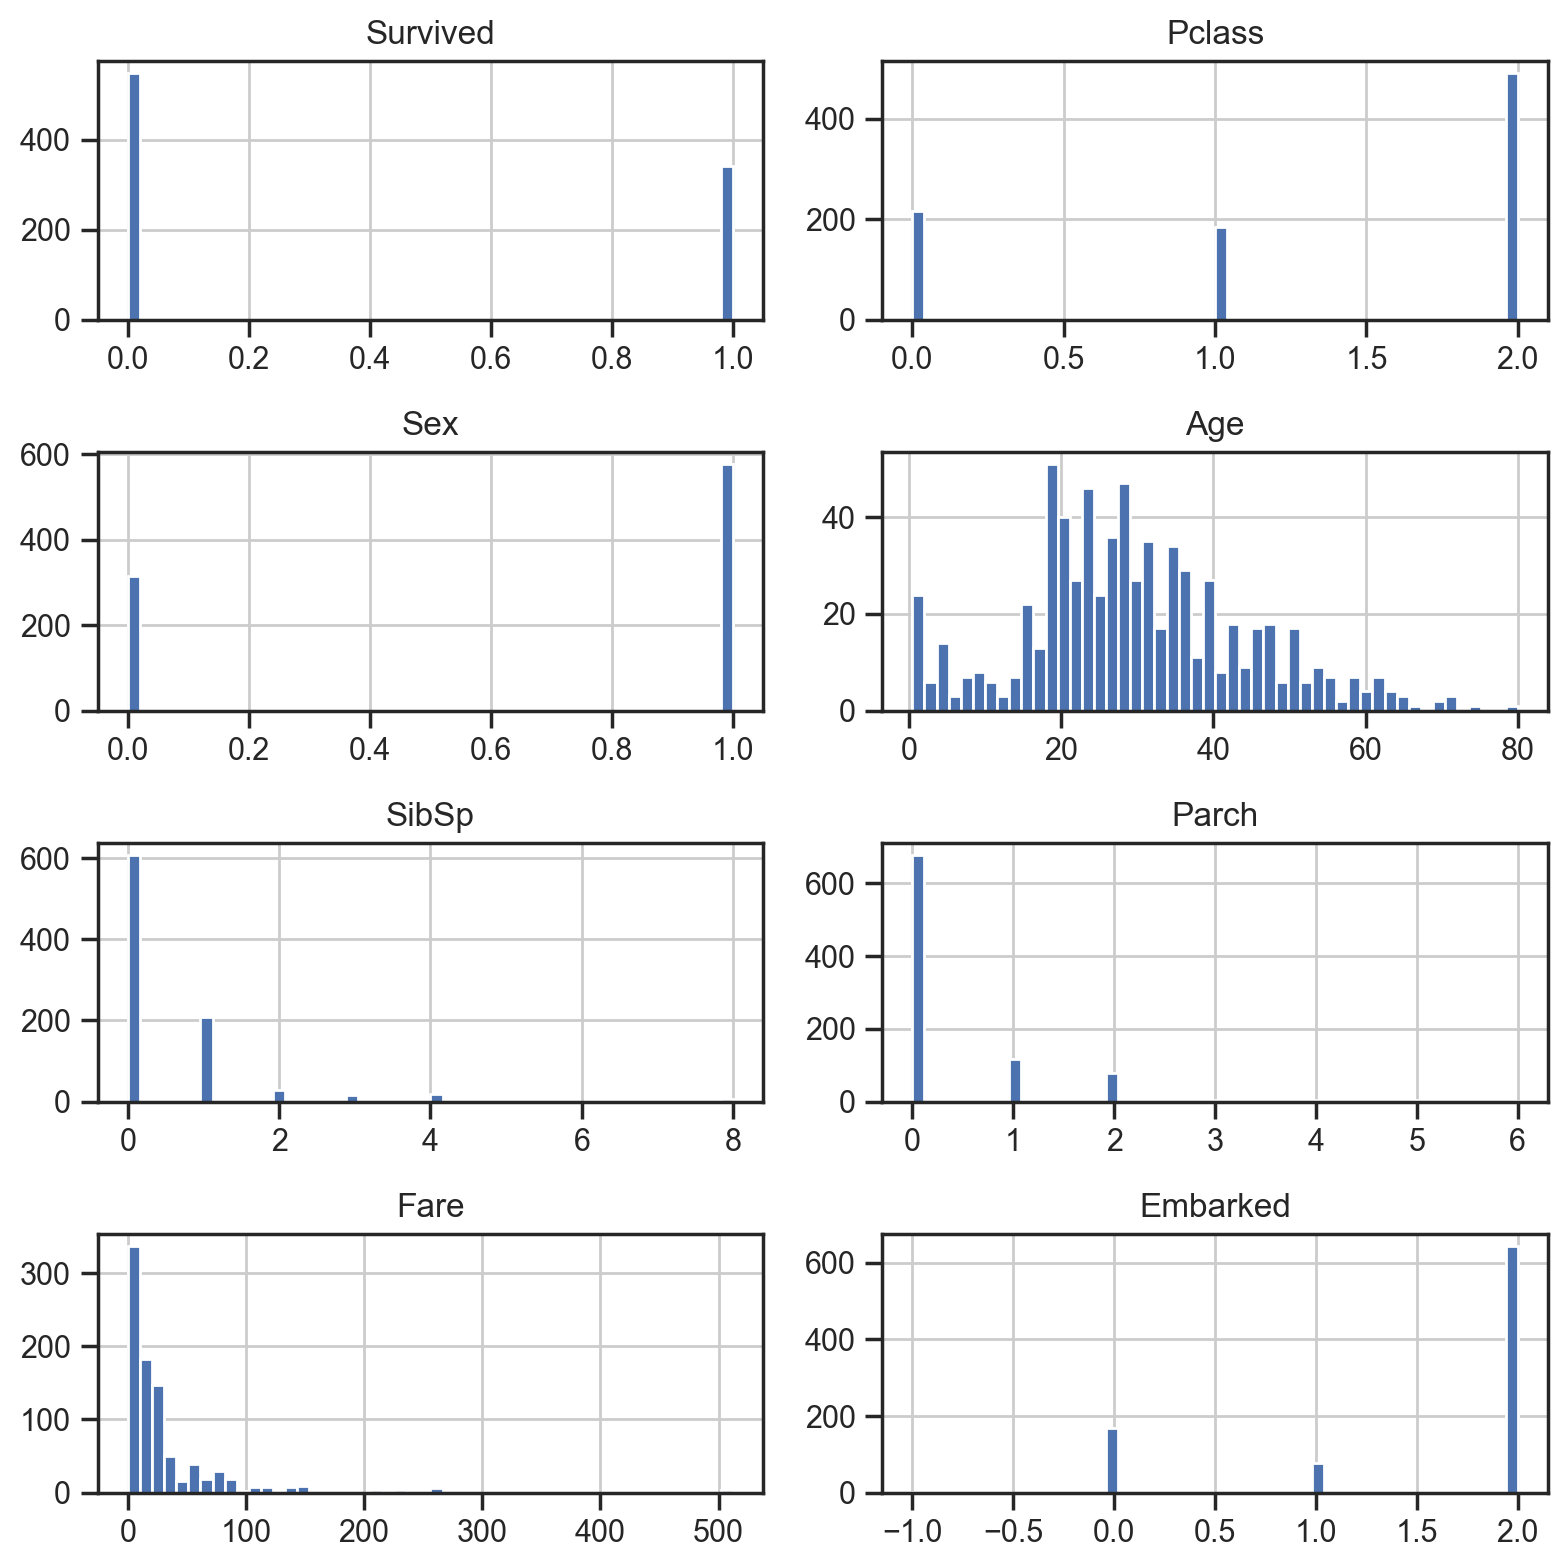

In [2]:
## DROP IRRELEVANT OR ERRONEOUS FEATURES
features_to_drop = ["PassengerId","Name","Ticket","Cabin"]
df = df_train.drop(columns=features_to_drop)

## RE-TYPE CATEGORICAL VARIABLES
numeric = ["Age","Fare","SibSp","Parch"]
categorical = ["Survived","Pclass","Sex","Embarked"]
for feat in categorical: 
    df[feat] = df[feat].astype('category')

## CONVERT CATEGORICAL VARIABLES TO NUMERIC REPRESENTATIONS
hist_df = df.copy()
hist_df[categorical] = hist_df[categorical].apply(lambda x: x.cat.codes)
print(pd.concat((hist_df.iloc[0], hist_df.dtypes), keys=["Sample", "Datatypes"], axis=1))

## EXAMINE HOW EACH FEATURE IS DISTRIBUTED AND LOOK FOR OUTLIERS
plt.clf()
hist_df.hist(bins=50, figsize=(8,8), layout=(4,2))
plt.tight_layout()

The remaining features have relatively friendly distributions. Fare has a few very large outliers, but that is not so alarming given that this was the maiden voyage of the largest ship in the world at the time. Age appears very roughly normal, with a lot of newborns and a skew towards the elderly age group. There are weird spikes throughout the distribution, which may correspond with the missing data. I would expect this distribution to look more smooth and less spikey after imputation. 

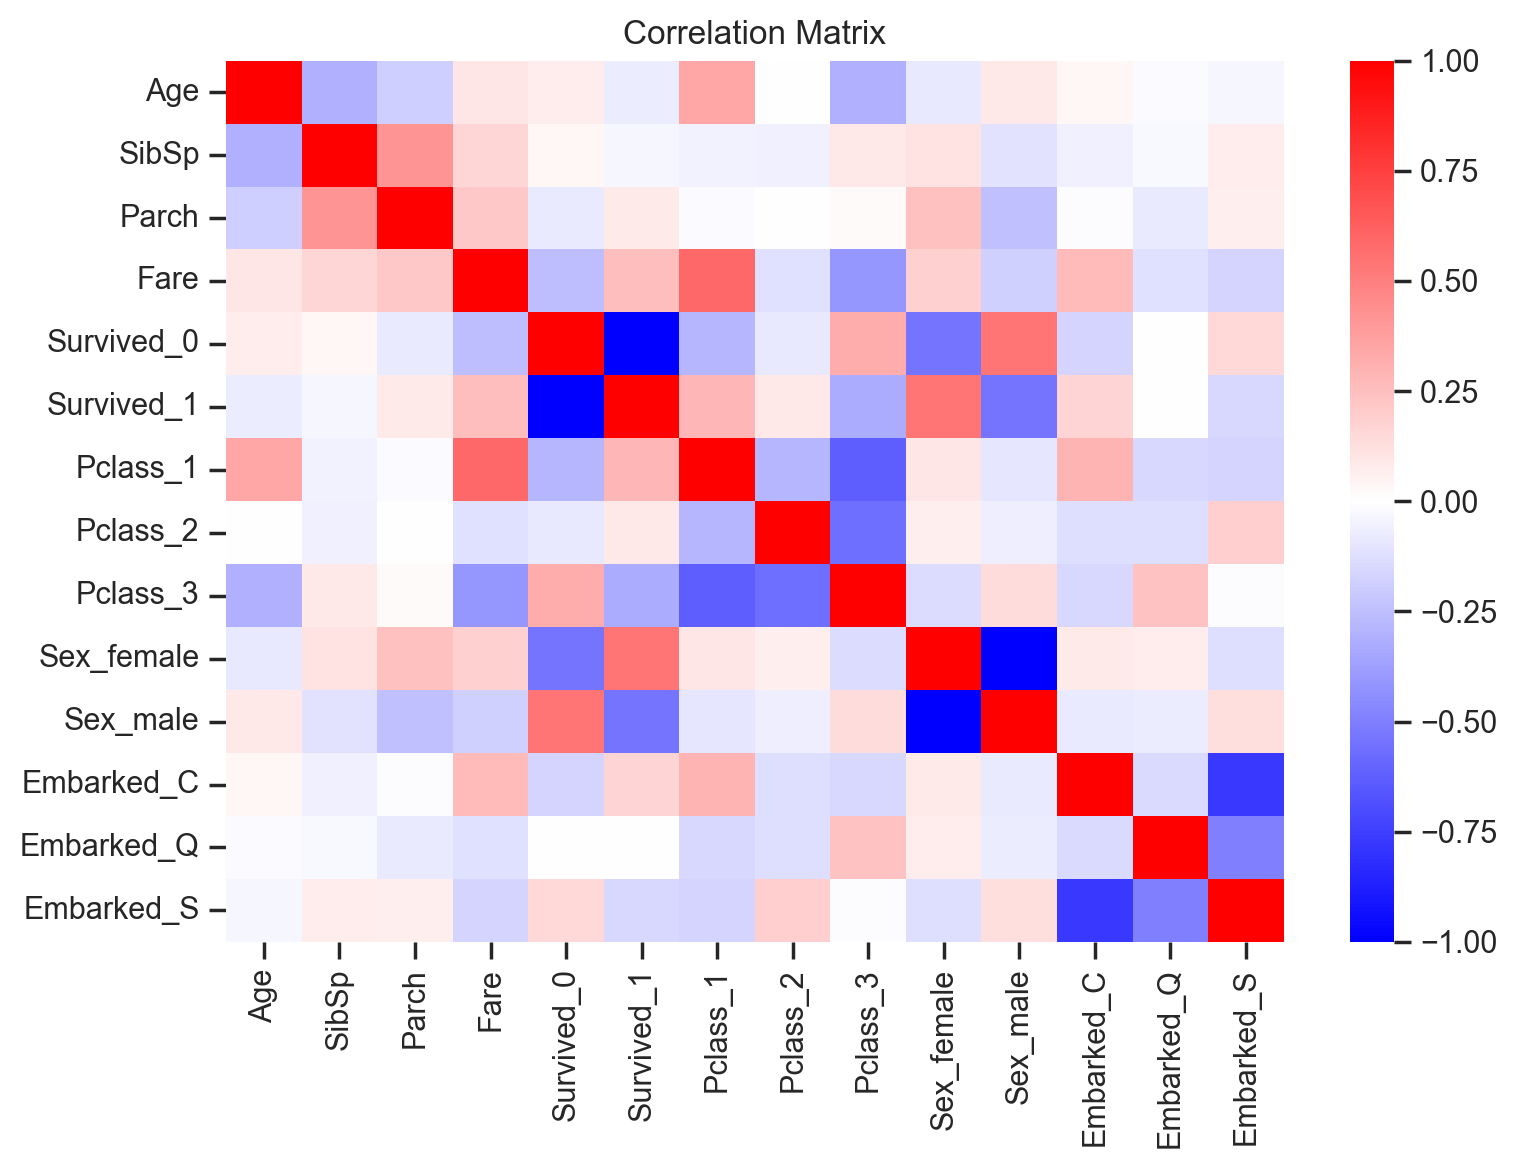

In [3]:
## CONVERT CATEGORICAL TO ONE-HOT REPRESENTATIONS
df = pd.get_dummies(df)

## EXAMINE CORRELATIONS BETWEEN FEATURES
plt.clf()
heatmap = sns.heatmap(df.corr(), cmap="bwr")
heatmap.set_title("Correlation Matrix")
plt.tight_layout()

We have a very rich mix of positively and negatively correlated features. Sex has by far the strongest correlation with whether a passenger survived, followed by fair and passenger class, which largely describe the same thing. We also see a reasonable correlation with embarkation at Cherbourg (positive) and Southampton (negative). Age appears much less correlated with survival than I originally anticipated.

<Figure size 1600x1200 with 0 Axes>

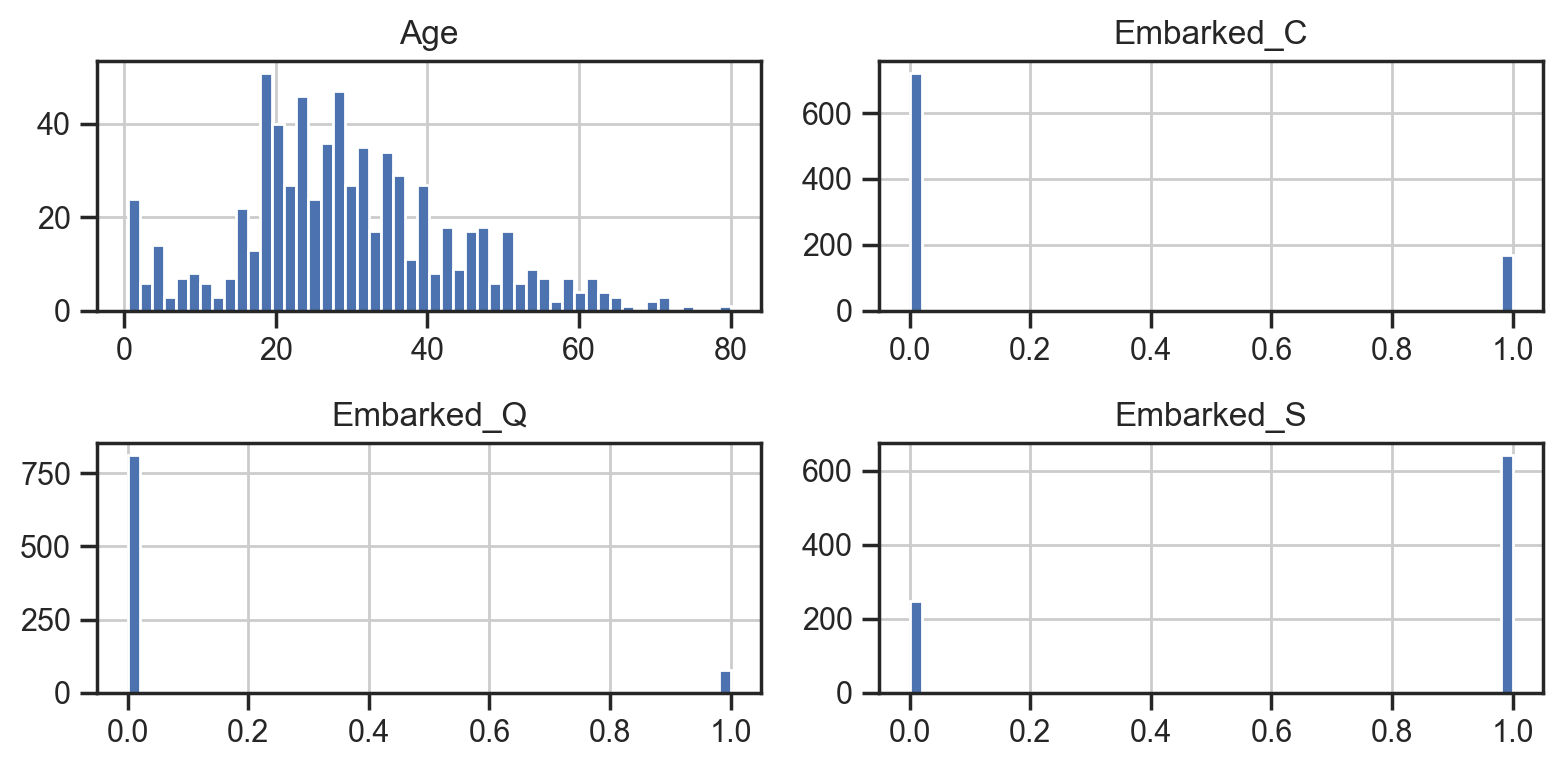

In [4]:
## PLOT DISTRIBUTIONS BEFORE IMPUTING
plt.clf()
df.hist(column=["Age","Embarked_C", "Embarked_Q", "Embarked_S"], bins=50, figsize=(8,4), layout=(2,2))
plt.tight_layout()

<Figure size 1600x1200 with 0 Axes>

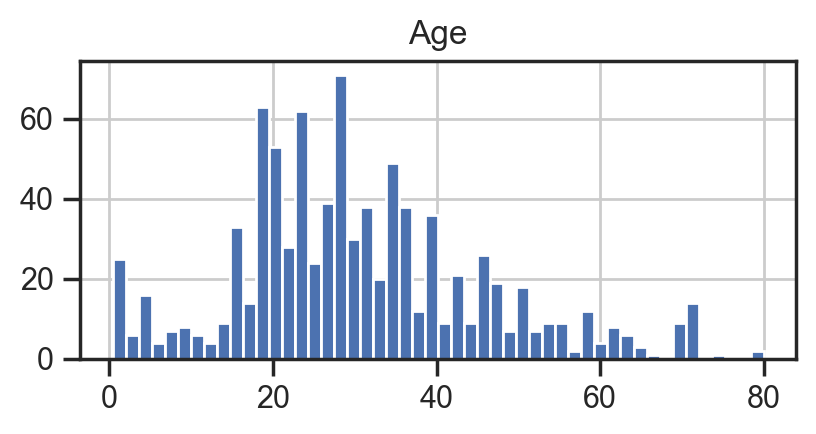

In [5]:
## NEAREST NEIGHBOR IMPUTATION K = 1
from sklearn.impute import KNNImputer
imputer_k1 = KNNImputer(n_neighbors=1)
impute_df = pd.DataFrame(imputer_k1.fit_transform(df), columns=df.columns)

## PLOT DISTRIBUTIONS AFTER IMPUTING
plt.clf()
impute_df.hist(column=["Age"], bins=50, figsize=(8,4), layout=(2,2))
plt.tight_layout()

<Figure size 1600x1200 with 0 Axes>

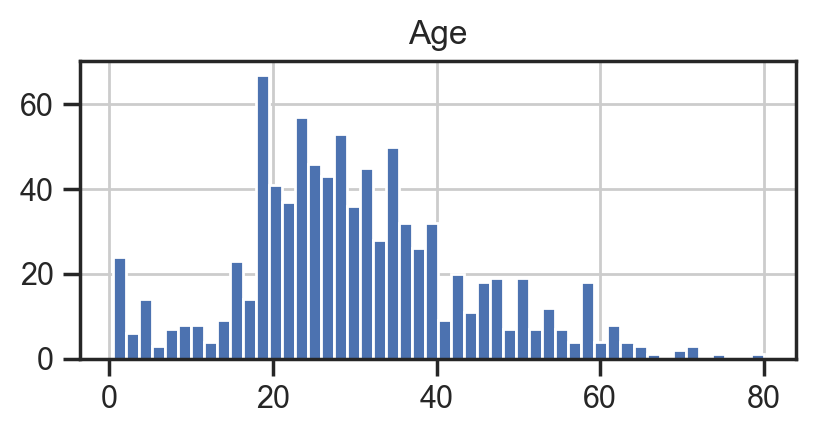

In [6]:
## NEAREST NEIGHBOR IMPUTATION K = 3
imputer_k3 = KNNImputer(n_neighbors=3)
impute_df = pd.DataFrame(imputer_k3.fit_transform(df), columns = df.columns)

## PLOT DISTRIBUTIONS AFTER IMPUTING
plt.clf()
impute_df.hist(column=["Age"], bins=50, figsize=(8,4), layout=(2,2))
plt.tight_layout()

<Figure size 1600x1200 with 0 Axes>

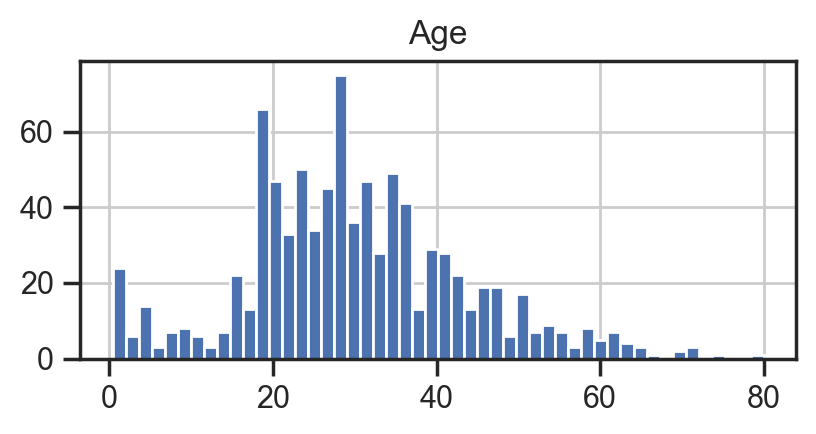

In [7]:
## NEAREST NEIGHBOR IMPUTATION K = 7
imputer_k7 = KNNImputer(n_neighbors=7)
impute_df = pd.DataFrame(imputer_k7.fit_transform(df), columns = df.columns)

## PLOT DISTRIBUTIONS AFTER IMPUTING
plt.clf()
impute_df.hist(column=["Age"], bins=50, figsize=(8,4), layout=(2,2))
plt.tight_layout()

After imputing age using KNN with several values of K, it appears that K=3 gives the least variation between adjacent age bins, giving it the most normal shape of the parameters tested. That is what we will use for training. 

Now that we have cleaned and imputed the data, we can train a Random Forest Classifier using 10-fold cross validation. I believe Random Forest is a good selection because half of our features are numeric and half are categorical, and it readily learns on both modalities. It also allows us to train without needing to normalize the data. 

In [8]:
## FINALIZE THE TRAINING SET
df = pd.DataFrame(imputer_k3.transform(df), columns=df.columns)
X = df.drop(columns=["Survived_0","Survived_1"]).values
y = df["Survived_1"].values

## TRAIN MODEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold    
from sklearn import metrics
import numpy as np 

def train(model_class, model_config, X, y, k=10, shuffle=False):
    ## K-FOLD CROSS VALIDATION
    acc, conf = [], []
    kfold = KFold(n_splits=k, shuffle=shuffle)
    for i_train, i_test in kfold.split(X, y):
        
        ## TRAIN MODEL
        model = model_class(**model_config)
        model.fit(X[i_train], y[i_train])
        y_pred = model.predict(X[i_test])

        ## COMPUTE METRICS
        conf.append(metrics.confusion_matrix(y[i_test], y_pred))
        acc.append(metrics.accuracy_score(y[i_test], y_pred))

    return acc, conf

model_config = {"n_estimators":10, "max_features":8}
acc, conf = train(RandomForestClassifier, model_config, X, y, k=10, shuffle=True)


## ANALYZE RESULTS
print(f"Accuracy per fold: {'%, '.join(np.round(100*np.array(acc),2).astype(str))}")
print(f"10-Fold Mean Accuracy: {100*np.mean(acc):.4}%")

conf = np.array(conf)
tpr = conf[:, 0,0] / (conf[:, 0,0] + conf[:, 1,0] + 1e-10)
fpr = conf[:, 0,1] / (conf[:, 0,0] + conf[:, 0,1] + 1e-10)
print(f"10-Fold Mean True Positive Rate: {100*np.mean(tpr):.4}%")
print(f"10-Fold Mean False Positive Rate: {100*np.mean(fpr):.4}%")

Accuracy per fold: 76.67%, 89.89%, 84.27%, 79.78%, 78.65%, 85.39%, 87.64%, 82.02%, 77.53%, 83.15
10-Fold Mean Accuracy: 82.5%
10-Fold Mean True Positive Rate: 83.57%
10-Fold Mean False Positive Rate: 10.88%


In [9]:
## RETRAIN FINAL MODEL ON FULL DATASET
model = RandomForestClassifier(**model_config)
model.fit(X, y)
y_pred = model.predict(X)

final_acc = metrics.accuracy_score(y, y_pred)
final_conf = metrics.confusion_matrix(y, y_pred)
final_tpr = final_conf[0,0] / (final_conf[0,0] + final_conf[1,0] + 1e-10)
final_fpr = final_conf[0,1] / (final_conf[0,0] + final_conf[0,1] + 1e-10)
print(f"Full Training Set Accuracy: {100*final_acc:.4}%")
print(f"Full Training Set True Positive Rate: {100*final_tpr:.4}%")
print(f"Full Training Set False Positive Rate: {100*final_fpr:.4}%")

Full Training Set Accuracy: 97.98%
Full Training Set True Positive Rate: 97.5%
Full Training Set False Positive Rate: 0.7286%


2. [30 pts] Submit your predictions to Kaggle for the test dataset and report your accuracy in your submission. (You will need a Kaggle account – use a dummy email address if you prefer to protect your school email address, etc.) For your reference, I achieved 79% using my preprocessing pipeline and a Random Forest classifier. This is not the best, as in Kaggle there are better results. Kaggle also has some results with 100% accuracy, which cannot be taken as honest submissions in my opinion. 

Use the following code to export your predictions into a .csv format Kaggle will accept: 

```
def save_preds(_fn, _y_pred, _df): 

  import csv 
  with open(_fn, 'w') as fout: 
    writer = csv.writer(fout, delimiter=',', lineterminator='\n') 
    writer.writerow(['PassengerId', 'Survived']) 
    for yid, ypred in zip(_df['PassengerId'], _y_pred): 
      writer.writerow([yid, ypred]) 
       
save_preds('predictions_erhan.csv', y_pred, df_test_org) 
```

Note that in the above code the dataset _df has to include the 'PassengerId', which must not be used for the classification model. Kaggle needs it to compute a performance score. 
 


                       Sample Datatypes      NaN %  Num Categories
PassengerId               892     int64   0.000000             418
Pclass                      3     int64   0.000000               3
Name         Kelly, Mr. James    object   0.000000             418
Sex                      male    object   0.000000               2
Age                      34.5   float64  20.574163              79
SibSp                       0     int64   0.000000               7
Parch                       0     int64   0.000000               8
Ticket                 330911    object   0.000000             363
Fare                   7.8292   float64   0.239234             169
Cabin                     NaN    object  78.229665              76
Embarked                    Q    object   0.000000               3


<Figure size 1600x1200 with 0 Axes>

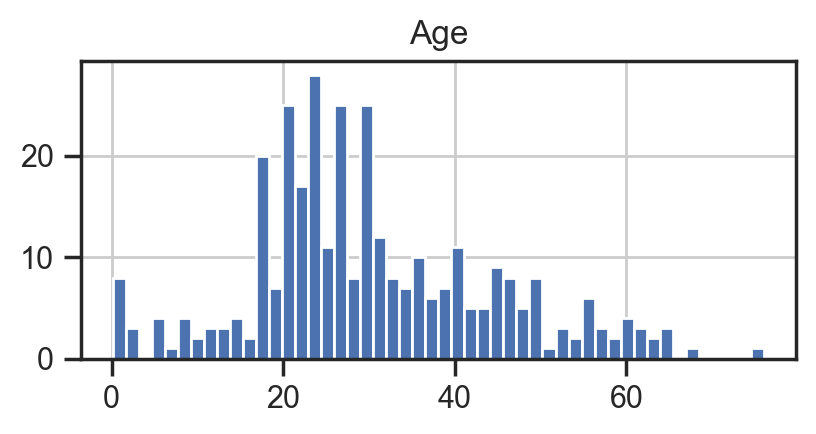

In [10]:
## PRE-PROCESS TEST DATASET
df_test = pd.read_csv("test.csv")                    
sample = df_test.iloc[0]
dtypes = df_test.dtypes
nans = 100 * df_test.isna().sum() / len(df_test)
categories = df_test.nunique()
print(pd.concat(
    (sample, dtypes, nans, categories), 
    keys=["Sample", "Datatypes", "NaN %", "Num Categories"], 
    axis=1)
)

## DROP FEATURES
df_passenger_id = pd.DataFrame(df_test["PassengerId"])
df_test = df_test.drop(columns=features_to_drop)                                                

## ONE-HOT ENCODING
for feat in categorical[1:]:                            
    df_test[feat] = df_test[feat].astype('category')                                       
df_test = pd.get_dummies(df_test)                       

## EXAMINE AGE BEFORE IMPUTING
plt.clf()
df_test.hist(column=["Age"], bins=50, figsize=(8,4), layout=(2,2))
plt.tight_layout()

<Figure size 1600x1200 with 0 Axes>

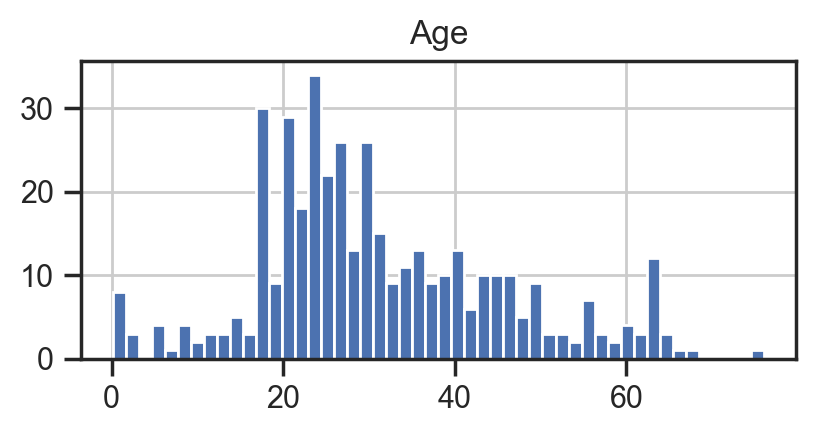

In [11]:
## FIT A NEW IMPUTER ON BOTH THE TRAIN AND TEST SET
df_combined = pd.concat((df, df_test)).drop(columns=["Survived_0","Survived_1"])
test_imputer = KNNImputer(n_neighbors=3)
test_imputer.fit_transform(df_combined)

## APPLY IMPUTER TO THE TEST SET
df_test = pd.DataFrame(                                 
    test_imputer.transform(df_test),                    
    columns=df_test.columns                             
)
## EXAMINE AGE BEFORE IMPUTING
plt.clf()
df_test.hist(column=["Age"], bins=50, figsize=(8,4), layout=(2,2))
plt.tight_layout()

<Figure size 1600x1200 with 0 Axes>

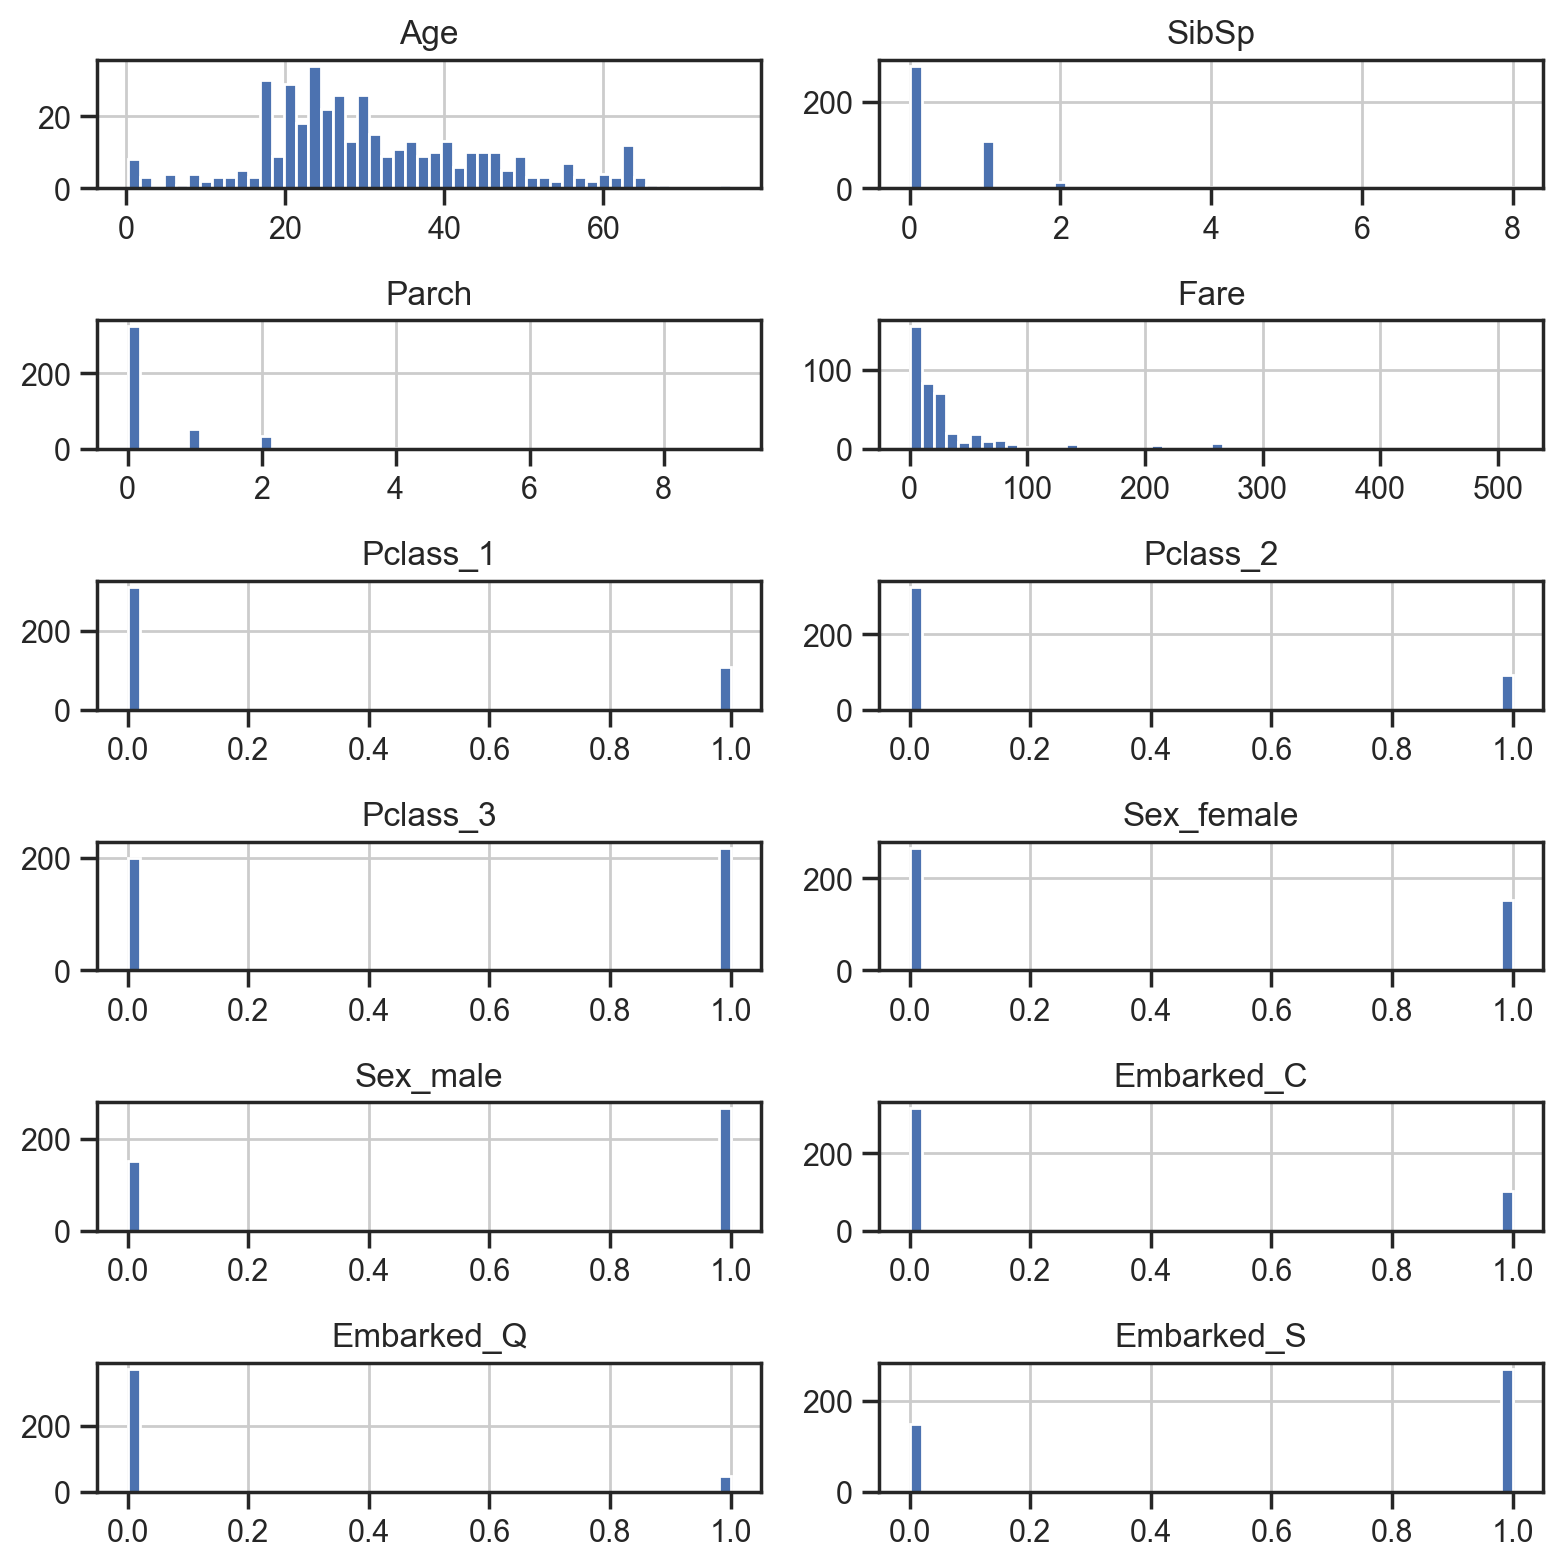

In [12]:
## EXAMINE FEATURE DISTRIBUTIONS AFTER PRE-PROCESSING
plt.clf()
df_test.hist(bins=50, figsize=(8,8), layout=(6,2))
plt.tight_layout()

In [13]:
## PRODUCE TEST SET PREDICTIONS
X_test = df_test.values
y_test_pred = model.predict(X_test).astype(int)

def save_preds(filepath, y_pred, df): 

    import csv 
    with open(filepath, 'w') as fout: 
        writer = csv.writer(fout, delimiter=',', lineterminator='\n') 
        writer.writerow(['PassengerId', 'Survived']) 
        for yid, ypred in zip(df['PassengerId'], y_pred): 
            writer.writerow([yid, ypred]) 
       
save_preds('predictions_brothers.csv', y_test_pred, df_passenger_id) 

My submission got an accuracy score of 74.88%. Given that the upper bound model performance on the training set was just over 82%, I think this accuracy is decent. I believe it could be improved with more thorough hyperparameter tuning or exploring alternative classifiers. I could also do more trials with different pre-processing approaches, such as an alternative imputing scheme. 

You could also use the kaggle submission score as a validation metric to tune your model, which seems like a form of cheating. I assume the people that got perfect accuracy just used a similar brute force approach of uploading submissions until they got all of the predictions correct. 